# Shapley effects for the Rust Model

In [1]:
# Import statements as in simulation_convergence.ipynb.
import matplotlib.pyplot as plt
#import yaml
import numpy as np
from ruspy.simulation.simulation import simulate
from ruspy.model_code.fix_point_alg import calc_fixp
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.estimation.estimation_transitions import create_transition_matrix

# Additional imports from get_demand module.
from ruspy.estimation.estimation_interface import select_model_parameters
from ruspy.model_code.choice_probabilities import choice_prob_gumbel

# Additional import from tutorial uncertainty propagation.
import matplotlib as mpl

# My imports.
import chaospy as cp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ruspy.estimation.estimation import estimate
from ruspy.model_code.demand_function import get_demand
from python.econsa_shapley import get_shapley
from python.econsa_shapley import _r_condmvn

## Understand simulation capabilities of `ruspy`
The below code is taken from the notebook simulation_convergence provided as promotional material for `ruspy`.

In [2]:
# Set simulating variables
disc_fac = 0.9999
num_buses = 50
num_periods = 120
gridsize = 1000
# We use the cost parameters and transition probabilities from the replication
params = np.array([10.07780762, 2.29417622])
trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])
scale = 1e-3

init_dict_sim = {
    "simulation": {
        "discount_factor": disc_fac,
        "periods": num_periods,
        "seed": 123,
        "buses": num_buses,
    },
    "plot": {"gridsize": gridsize},
}

In [3]:
# Calucalte objects necessary for the simulation process. See documentation for details.
num_states = 200
costs = calc_obs_costs(num_states, lin_cost, params, scale)

trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(trans_mat, costs, disc_fac)[0]

In [4]:
# Can use one init_dict for get_demand() and estimate().
init_dict_estimation = {
    'model_specifications': {
        'discount_factor': disc_fac,
        'number_states': num_states,
        'maint_cost_func': 'linear',
        'cost_scale': 1e-3
    },
    'optimizer': {
        'approach': 'NFXP',
        'algorithm': 'scipy_L-BFGS-B',
        'gradient': 'Yes'
    },
    
}

In [5]:
%%time

# Define number of simulations.
num_sim = 100

# Initialize array to save parameter estimates.
parameter_estimates = np.zeros((num_sim, len(trans_probs) + len(params) -1))

for i in np.arange(num_sim):
    
    init_dict_sim['simulation']['seed'] = +i
    
    df = simulate(init_dict_sim["simulation"], ev, costs, trans_mat)
    data = df[['state', 'decision', 'usage']].copy()
    
    result_transitions_nfxp, result_fixp_nfxp = estimate(init_dict_estimation, data)
    
    # Record only two of three transition probabilities i.o.t. avoid singularity of the covariance matrix.
    parameter_estimates[i, :] = np.concatenate((result_transitions_nfxp['x'][:2], result_fixp_nfxp['x']))

Wall time: 4min 41s


In [6]:
cov = np.cov(parameter_estimates.T)

In [7]:
mean = np.mean(parameter_estimates, axis=0)

In [8]:
distribution = cp.MvNormal(mean, cov)
parameter_samples = pd.DataFrame(data=(distribution.sample(1000).T),
                                 columns=('t_30', 't_31', 'RC', 't_11'),
                                )

In [9]:
parameter_samples

,t_30,t_31,RC,t_11
0,0.390771,0.594243,13.020443,3.563283
1,0.401584,0.583803,10.207463,2.195900
2,0.390502,0.597463,7.274183,0.490257
3,0.390628,0.595334,8.862660,1.868585
4,0.391315,0.596972,11.486418,2.573254
...,...,...,...,...
995,0.391268,0.596045,11.387166,2.611934
996,0.388125,0.600327,9.894432,2.186753
997,0.391980,0.595824,9.365398,2.047078
998,0.401313,0.585264,11.873053,3.039995


In [10]:
# Add third transition probability: t_32 = 1 - t_30 - t_31
parameter_samples['t_32'] = 1 - parameter_samples['t_30'] - parameter_samples['t_31']

In [11]:
parameter_samples

,t_30,t_31,RC,t_11,t_32
0,0.390771,0.594243,13.020443,3.563283,0.014987
1,0.401584,0.583803,10.207463,2.195900,0.014613
2,0.390502,0.597463,7.274183,0.490257,0.012036
3,0.390628,0.595334,8.862660,1.868585,0.014038
4,0.391315,0.596972,11.486418,2.573254,0.011712
...,...,...,...,...,...
995,0.391268,0.596045,11.387166,2.611934,0.012687
996,0.388125,0.600327,9.894432,2.186753,0.011549
997,0.391980,0.595824,9.365398,2.047078,0.012196
998,0.401313,0.585264,11.873053,3.039995,0.013423


In [12]:
# Plot distributions.
#sns.jointplot(data=parameter_samples, x='RC', y='t_11')

In [13]:
# Plot distributions.
#sns.displot(parameter_samples, x='RC', y='t_11')

In [14]:
# Plot distributions.
#sns.pairplot(parameter_samples)

### Calculate demand level from structural parameter estimates

In [15]:
# Sample data.
n_sim_demand = 100
input_variables = cp.MvNormal(mean, cov).sample(n_sim_demand).T

In [16]:
#input_variables

In [17]:
n_inputs = 5
inputs = np.zeros((n_sim_demand, n_inputs))

In [18]:
# Fill the inputs array.
inputs[:,:2] = input_variables[:,:2]
# At third position insert thrid transition probability.
inputs[:, 2] = 1 - input_variables[:, 0] - input_variables[:, 1]
inputs[:, 3:] = input_variables[:, 2:]

In [19]:
#inputs

In [20]:
# Need demand at certain value of RC only.
demand_dict = {
    "RC_lower_bound": 4,
    "RC_upper_bound": 13,
    "demand_evaluations": 100,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}
demand_params = inputs[0, :]

In [21]:
#demand = get_demand(init_dict_estimation, demand_dict, demand_params)
#demand.head()

In [22]:
#sns.jointplot(data=demand, x='demand', y='RC')

In [23]:
#plt.plot(demand.index.to_numpy(), demand["demand"].astype(float).to_numpy())
#plt.xlabel("Replacement Cost")
#plt.ylabel("Expected Implied Annual Demand")

### Demand at certain value of RC. 

In [24]:
# Need demand at certain value of RC only.
demand_dict = {
    "RC_lower_bound": 11.5,
    "RC_upper_bound": 11.5,
    "demand_evaluations": 1,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}

In [25]:
%%time
# Intitialize for loop for calculating implied demand for input samples.
implied_demand = np.zeros(n_sim_demand)
for sample in np.arange(n_sim_demand):
    demand_params = inputs[sample, :]
    demand = get_demand(init_dict_estimation, demand_dict, demand_params)
    implied_demand[sample] = demand.iloc[0][0]

Wall time: 35.4 s


In [26]:
np.sort(implied_demand)

array([41.18559702, 44.54044713, 46.56648892, 47.58220213, 48.11767983,
       49.22227188, 50.60436546, 50.90399001, 51.22387004, 52.13633698,
       52.26752485, 52.42001878, 53.42812719, 54.23622818, 54.74377466,
       54.77252748, 55.53678424, 55.83960776, 55.90795572, 56.08738928,
       56.20753005, 56.34998858, 57.01994904, 57.90630887, 58.02332479,
       58.40109446, 58.61928379, 58.91691161, 59.04503965, 59.29468616,
       59.46854242, 59.6148217 , 59.79397906, 60.29246091, 60.61076408,
       60.84555446, 60.90083081, 60.93471647, 61.04195285, 61.08285999,
       61.1932676 , 61.36481111, 61.48134575, 61.54250744, 61.58737669,
       61.73655516, 61.89650386, 62.09615642, 62.38349671, 62.41809089,
       62.66193403, 63.12522208, 63.20830227, 63.28989014, 63.35008356,
       63.38870638, 63.39381818, 63.56741141, 63.57755807, 64.10003303,
       64.31294351, 64.50909021, 64.99216649, 65.00801817, 65.08926379,
       65.10452277, 65.26532359, 65.34809481, 65.79684157, 65.99

In [27]:
np.min(implied_demand)

41.185597024788095

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.0, ''),
 Text(0, 0.01, ''),
 Text(0, 0.02, ''),
 Text(0, 0.03, ''),
 Text(0, 0.04, ''),
 Text(0, 0.05, ''),
 Text(0, 0.06, ''),
 Text(0, 0.07, '')]

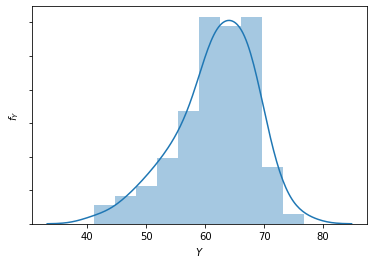

In [28]:
fig, ax = plt.subplots()

sns.distplot(implied_demand)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$f_Y$")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.axes.get_yaxis().set_ticklabels([])

### Shapley effects for the Rust model
 1. Define functions `rust_model()`, `x_all()`, and `x_cond()`.
 2. Set parameters for `get_shapley()`.
 3. Run `get_shapley()`.

In [29]:
# Define x_all and x_cond. Can use functions from tutorial of Shapley effects and adapt them.
#def x_all(n):
#    sampled_parameters = cp.MvNormal(mean, cov).sample(n)
#    out = np.zeros((n_inputs, n))
#    # Due to singularity of cov one transition prob. needed to be left out which is now reintroduced.
#    out[:2, :] = sampled_parameters[:2, :]
#    out[2, :] = 1- sampled_parameters[0, :] - sampled_parameters[1, :]
#    out[3:, :] = sampled_parameters[2:, :]
#    return out

In [30]:
#test_sample = x_all(10)

In [31]:
# Test whether first elements sum up to one.
#np.sum(test_sample[:3, :], axis=0)

In [32]:
#def x_cond(n, subset_j, subsetj_conditional, xjc):
#    if subsetj_conditional is None:
#        if 2 in subset_j:
            #  Position of 2 in subsetj_conditional.
            # Calc theta_32 (input with index 2) as lin. comb. of index 1 and 2.
            # return statement.
#        else:
            
#        cov_int = np.array(cov)
#        cov_int = cov_int.take(subset_j, axis = 1)
#        cov_int = cov_int[subset_j]
#        sampled_parameters = cp.MvNormal(mean[subset_j], cov_int).sample(n)

        
#    else:
#        return _r_condmvn(n, mean = mean, cov = cov, dependent_ind = subset_j, given_ind = subsetj_conditional, x_given = xjc)

#### 1. Define functions 

In [33]:
def x_all(n):
    distribution = cp.MvNormal(mean, cov)
    return distribution.sample(n)

def x_cond(n, subset_j, subsetj_conditional, xjc):
    if subsetj_conditional is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(subset_j, axis = 1)
        cov_int = cov_int[subset_j]
        distribution = cp.MvNormal(mean[subset_j], cov_int)
        return distribution.sample(n)
    else:
        return _r_condmvn(n, mean = mean, cov = cov, dependent_ind = subset_j, given_ind = subsetj_conditional, x_given = xjc)

In [34]:
n = 10
data = x_all(n).T

In [35]:
data

array([[ 0.38976975,  0.59688056, 11.68727717,  2.97892115],
       [ 0.38709299,  0.59999667,  9.43919183,  1.94814229],
       [ 0.3911731 ,  0.59560434, 10.9126508 ,  2.53879817],
       [ 0.396003  ,  0.59149601, 10.3458738 ,  2.29048956],
       [ 0.3819229 ,  0.60589899, 12.41598313,  3.1726499 ],
       [ 0.39089175,  0.59641157, 10.99567023,  2.8091748 ],
       [ 0.38207904,  0.60563963,  8.75648868,  1.66918129],
       [ 0.38752426,  0.59878595, 12.30003547,  2.77411385],
       [ 0.39200792,  0.59548125, 10.43534727,  2.15669   ],
       [ 0.38236847,  0.60408797, 10.8487714 ,  2.47537998]])

In [67]:
def rust_model(x):
    if method == 'exact':
        n_evaluations = n_output + np.math.factorial(n_inputs) * (n_inputs -1) * n_outer * n_inner
    elif method == 'random':
        n_evaluations = n_output + n_perms * (n_inputs -1) * n_outer * n_inner
    demand_inputs = np.zeros((n_evaluations, 5))
    demand_inputs[:, :2] = x[:, :2]
    demand_inputs[:, 2] = 1 - x[:, 0] - x[:, 1]
    demand_inputs[:, 3:] = x[:, 2:]
    
    demand_output = np.zeros((n_evaluations, 1))
    
    for sample in np.arange(n_evaluations):
        demand_params = demand_inputs[sample, :]
        demand_output[sample] = get_demand(init_dict_estimation, demand_dict, demand_params).iloc[0][0]
        
    return demand_output

In [41]:
%%time
#rust_model(data)

Wall time: 0 ns


#### 2. Set parameters for `get_shapley()` 

In [81]:
n_inputs = 4
method = 'random'
np.random.seed(1234)
n_perms = 10
n_output = 10**2
n_outer = 10
n_inner = 3

In [64]:
n_output + np.math.factorial(n_inputs) * (n_inputs -1) * n_outer * n_inner

2260

In [80]:
# Approximate time for computation in hours (approx. 35 s per 100 model evaluations).
if method == 'random':
    time = (35 * (n_output + n_perms * (n_inputs -1) * n_outer * n_inner) / 100) / 3600
elif method == 'exact':
    time = (35 * (n_output + np.math.factorial(n_inputs) * (n_inputs -1) * n_outer * n_inner) / 100) / 3600
print('', time, 'hours', '\n', time * 60, 'minutes')

 0.21972222222222224 hours 
 13.183333333333334 minutes


#### 3. Run `get_shapley()` 

In [68]:
%%time
random_shapley = get_shapley(method, rust_model, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)

Wall time: 6min 5s


In [69]:
random_shapley

,Shapley effects,std. errors,CI_min,CI_max
X1,-0.077030,0.084621,-0.242887,0.088828
X2,-0.202446,0.133868,-0.464826,0.059935
X3,0.720530,0.172884,0.381677,1.059382
X4,0.558946,0.224862,0.118215,0.999676


In [70]:
shapley_effects_rust = random_shapley.copy()

In [74]:
shapley_effects_rust.rename(index={'X1': 'theta_30', 'X2': 'theta_31', 'X3': 'RC', 'X4': 'theta_11'}, inplace=True)

In [75]:
shapley_effects_rust

,Shapley effects,std. errors,CI_min,CI_max
theta_30,-0.077030,0.084621,-0.242887,0.088828
theta_31,-0.202446,0.133868,-0.464826,0.059935
RC,0.720530,0.172884,0.381677,1.059382
theta_11,0.558946,0.224862,0.118215,0.999676


In [78]:
shapley_effects_rust['Shapley effects'].sum()

1.0